In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import networkx as nx
from pyvis import network as net
from math import floor, ceil

In [182]:
from sklearn.datasets import make_circles, make_blobs

# data = make_circles(n_samples = 2000, noise = 0.05, random_state = None, factor = 0.5)
data = make_blobs(n_samples = 5000, n_features = 5, random_state = 44)

In [183]:
labels = data[1]
data = data[0]

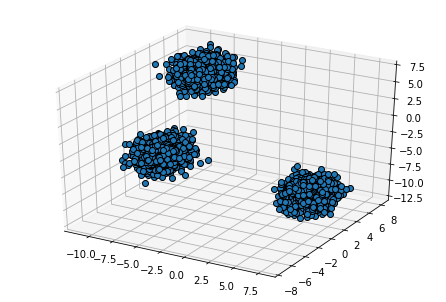

In [151]:
from mpl_toolkits.mplot3d import Axes3D
import random

x = [i[0] for i in data]
y = [i[1] for i in data]
z = [i[2] for i in data]

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(x, y, z, 'o', markeredgecolor = 'k', markersize = 6)
plt.show()

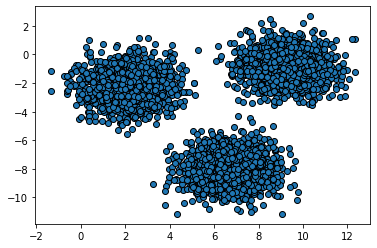

In [184]:
x = [i[0] for i in data]
y = [i[1] for i in data]

plt.plot(x, y,'o', markeredgecolor = 'k', markersize = 6)

In [185]:
def get_cover(range_, interval_len, overlap):
    assert len(range_) == len(interval_len) == len(overlap), "Dimension mismatch!"
    cover = []
    for i in range(len(range_)):
        range_min = range_[i][0]
        range_max = range_[i][1]
        intervals = []
        upto_low, upto_high = range_min, range_min + interval_len[i]
        while True:
            if upto_high >= range_max:
                intervals.append((upto_low, range_max))
                break

            intervals.append((round(upto_low, 10), round(upto_high, 10)))
            upto_low += (interval_len[i] - overlap[i])
            upto_high += (interval_len[i] - overlap[i])
        
        cover.append(intervals)
    
    return cover

cover = get_cover(range_ = [(-2, 13), (-12, 3)], interval_len = [2, 1], overlap = [0.5, 0.3])
print(cover)

[[(-2, 0), (-0.5, 1.5), (1.0, 3.0), (2.5, 4.5), (4.0, 6.0), (5.5, 7.5), (7.0, 9.0), (8.5, 10.5), (10.0, 12.0), (11.5, 13)], [(-12, -11), (-11.3, -10.3), (-10.6, -9.6), (-9.9, -8.9), (-9.2, -8.2), (-8.5, -7.5), (-7.8, -6.8), (-7.1, -6.1), (-6.4, -5.4), (-5.7, -4.7), (-5.0, -4.0), (-4.3, -3.3), (-3.6, -2.6), (-2.9, -1.9), (-2.2, -1.2), (-1.5, -0.5), (-0.8, 0.2), (-0.1, 0.9), (0.6, 1.6), (1.3, 2.3), (2.0, 3.0), (2.6999999999999975, 3)]]


In [186]:
def get_clusters(filter_func, cover, data):
    assert len(cover) == len(filter_func), "Dimension mismatch!"
    clusters = []
    
    def _get_clusters(filter_func, cover, data, __rec_num, __low, __high):
        if __rec_num < len(cover):
            for (low, high) in cover[__rec_num]:
                __low[__rec_num], __high[__rec_num] = low, high
                _get_clusters(filter_func, cover, data, __rec_num + 1, __low, __high)
        else:
            to_cluster = []
            for p in data:
                flag = True
                for i in range(len(__low)):
                    flag = flag and (filter_func[i](p) >= __low[i] and filter_func[i](p) <= __high[i])

                if flag:
                    to_cluster.append(p)

            if len(to_cluster):
                to_cluster = np.array(to_cluster)
                db = DBSCAN(algorithm = 'auto', eps = 1, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
                labels = np.array(db.labels_)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                for i in range(0, n_clusters):
                    clusters.append(set([tuple(p) for p in to_cluster[labels == i]]))
    
    l = len(filter_func)
    _get_clusters(filter_func, cover, data, __rec_num = 0, __low = [0] * l, __high = [0] * l)
    return clusters

def filter_func_1(p):
    return p[0]

def filter_func_2(p):
    return p[1]

filter_func = [filter_func_1, filter_func_2]
clusters = get_clusters(filter_func, cover, data)

In [188]:
from win32api import GetSystemMetrics

def create_graph(file_name):
    cluster_sizes = np.array([len(i) for i in clusters])
    max_nodes = max(cluster_sizes)
    g = net.Network(GetSystemMetrics(1), GetSystemMetrics(0), bgcolor="#222222")
    g.add_nodes(nodes = range(0, len(clusters), 1),
#                 size = [x / len(clusters) for x in cluster_sizes],
                title = ["Contains " + str(len(x)) + " elements" for x in clusters],
                label = [' '] * len(clusters),
                color = ['#%02x%02x%02x' % (255, 255 - int(len(i) / max_nodes * 255), 0) for i in clusters])
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i].intersection(clusters[j]):
                g.add_edge(i, j, color = '#ffdd00')

    g.set_options("""
    var options = {
    "nodes": {
        "shadow": {
        "enabled": true
        }
    },
    "edges": {
        "color": {
        "inherit": true
        },
        "smooth": true
    },
    "physics": {
        "barnesHut": {
        "centralGravity": 0,
        "springLength": 1,
        "springConstant": 0.01,
        "avoidOverlap": 0.5
        },
        "minVelocity": 0.75
    }
    }
    """)
    g.show(file_name)
    return g

graph = create_graph("example.html")

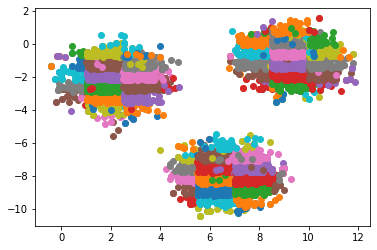

In [187]:
clusters_list = [list(cluster) for cluster in clusters]
X = [[p[0] for p in cluster] for cluster in clusters_list]
Y = [[p[1] for p in cluster] for cluster in clusters_list]
labels = range(1, len(X) + 1)

fig = plt.figure()
ax = fig.add_subplot(111)

colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])


for x,y,lab in zip(X,Y,labels):
        ax.scatter(x,y,label=lab)

(2, 2) (2,)
(14, 2) (14,)
(53, 2) (53,)
(100, 2) (100,)
(154, 2) (154,)
(201, 2) (201,)
(157, 2) (157,)
(103, 2) (103,)
(82, 2) (82,)
(52, 2) (52,)
(24, 2) (24,)
(35, 2) (35,)
(69, 2) (69,)
(130, 2) (130,)
(173, 2) (173,)
(198, 2) (198,)
(167, 2) (167,)
(166, 2) (166,)
(168, 2) (168,)
(185, 2) (185,)
(160, 2) (160,)
(151, 2) (151,)
(111, 2) (111,)
(69, 2) (69,)
(32, 2) (32,)
(9, 2) (9,)
(4, 2) (4,)


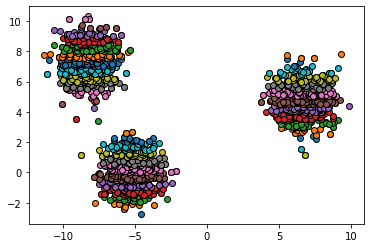

In [24]:
def get_clusters(filter_func, cover, data):
    clusters = []
    for (low, high) in intervals:
        to_cluster = list(filter(lambda p : p[1] >= low and p[1] <= high, data))
        if not len(to_cluster):
            continue
        
        to_cluster = np.array(to_cluster)
        x = [i[0] for i in to_cluster]
        y = [i[1] for i in to_cluster]
        plt.plot(x, y,'o', markeredgecolor='k', markersize=6)
        db = DBSCAN(algorithm = 'auto', eps = 0.3, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
        labels = np.array(db.labels_)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(to_cluster.shape, labels.shape)
        for i in range(0, n_clusters):
            clusters.append(set([tuple(p) for p in to_cluster[labels == i]]))
    
    return clusters

clusters = get_clusters(cover, data)

In [ ]:
def create_graph(clusters):
    adjacency_matrix = np.zeros([len(clusters)] * 2)
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i].intersection(clusters[j]):
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1
    
    adjacency_matrix = np.matrix(adjacency_matrix)
    graph = nx.from_numpy_matrix(adjacency_matrix)
    return graph

graph = create_graph(clusters)

In [ ]:
def visualize_graph(graph):
    g = net.Network(notebook = True)
    g.from_nx(graph)
    g.show("example.html")

visualize_graph(graph)